# Spatial Structure and Tactical Style in the UEFA Women’s Euro 2025

This project analyzes team spatial organization during the UEFA Women’s Euro 2025 using event-level match data.
Rather than focusing on traditional event counts (such as passes, shots, or duels), the goal is to understand
how teams structure themselves on the pitch across different phases of play.

To do this, I introduce and analyze two spatial metrics:
- **Compactness radius**, which measures how tightly a team is grouped around its center point
- **Space control**, measured using convex hull area to estimate the total space occupied by a team

By comparing these metrics across phases of play, this analysis addresses the following questions:
- How does team structure change between defending and attacking phases?
- Are these structural differences consistent across matches?
- What spatial information is captured that traditional box-score metrics fail to represent?

This project is structured as an end-to-end analysis, including data preparation, metric definition,
visualization, and interpretation, with the goal of evaluating whether spatial metrics meaningfully
capture tactical behavior in high-level women’s international soccer.

## Findings

- Teams consistently maintain a more compact structure when defending and expand their shape when in possession
- Differences in compactness across phases are systematic rather than random, reflecting intentional tactical organization
- Compactness and space control capture distinct aspects of team structure and should be interpreted together rather than interchangeably

## 1. Setup

### 1.1 Standard Library Imports


In [2]:
import pandas as pd
import numpy as np 
from pathlib import Path
import matplotlib.pyplot as plt
from statsbombpy import sb
import seaborn as sns

### 1.2 Custom Module Imports

In [14]:
from src.data_io import (
    load_euro_events,
    drop_mostly_null_columns,
    extract_xy_from_location,
    filter_play_events,
    add_phase_column,
)

from src.compactness import (
    compute_compactness, 
    clean_compactness,
    team_compactness_summary,
    compute_space_control,
)

from src.viz import (
    plot_avg_team_compactness,
    plot_team_compactness_maps,
)

In [15]:
pd.options.display.max_columns = 200


## 2. Data Loading

### 2.1 Load Euro 2025 Events Data

In [16]:
# Competition and season IDs for Women's Euro 2025
comp_id = 53
season_id = 315

# Load all events from Euro 2025 matches using refactored function
events = load_euro_events(comp_id=comp_id, season_id=season_id)
print(f"Loaded events shape: {events.shape}")

Loaded events shape: (105611, 113)
Loaded events shape: (105611, 113)


In [17]:
# Drop columns with ≥90% null values
events_clean, mostly_null = drop_mostly_null_columns(events, threshold=0.90)

print(f"Original columns: {len(events.columns)}")
print(f"Remaining columns: {len(events_clean.columns)}")
print(f"Dropped columns: {len(mostly_null)}")
print(f"\nTop 10 dropped columns:")
print(mostly_null.sort_values(ascending=False).head(10))

Original columns: 113
Remaining columns: 29
Dropped columns: 84

Top 10 dropped columns:
shot_follows_dribble                0.999991
goalkeeper_penalty_saved_to_post    0.999991
goalkeeper_lost_out                 0.999991
shot_redirect                       0.999981
ball_recovery_offensive             0.999981
goalkeeper_shot_saved_off_target    0.999953
pass_miscommunication               0.999953
shot_saved_off_target               0.999953
goalkeeper_punched_out              0.999943
goalkeeper_shot_saved_to_post       0.999943
dtype: float64


### 2.2 Extract X/Y Coordinates from Location


In [18]:
# Extract x and y coordinates from location column
events_clean = extract_xy_from_location(events_clean, location_col="location")
print(f"Sample events with coordinates:")
events_clean[["type", "team", "x", "y"]].head(10)


Sample events with coordinates:


,type,team,x,y
0,Starting XI,England Women's,NaN,NaN
1,Starting XI,Spain Women's,NaN,NaN
2,Half Start,England Women's,NaN,NaN
3,Half Start,Spain Women's,NaN,NaN
4,Half Start,England Women's,NaN,NaN
5,Half Start,Spain Women's,NaN,NaN
6,Half Start,England Women's,NaN,NaN
7,Half Start,Spain Women's,NaN,NaN
8,Half Start,England Women's,NaN,NaN
9,Half Start,Spain Women's,NaN,NaN


## 2.3 Clean Null Values Up 

In [19]:
# Filter out off-field events (Starting XI, Half Start/End, Substitutions, etc.)
events_play = filter_play_events(events_clean, type_col="type")

print("Event types after filtering:")
print(events_play["type"].value_counts().head(10))
print(f"\nTotal play events: {len(events_play)}")

Event types after filtering:
type
Pass             29108
Ball Receipt*    24646
Carry            22960
Pressure         11784
Ball Recovery     3512
Duel              2070
Block             1494
Clearance         1280
Goal Keeper       1184
Miscontrol         946
Name: count, dtype: int64

Total play events: 104506


## 3. Data Preparation

### 3.1 Prepare Data for Analysis

In [23]:
df = events_play.copy()
df = df.dropna(subset=["x", "y"])              
df = add_phase_column(df)  

In [24]:
# Compute compactness for all events
compactness = compute_compactness(df)
compactness.head(10)

,team,phase,possession,x_mean,y_mean,x_std,y_std,players_involved,event_count,compactness_radius
0,Belgium Women's,defending,2,66.493333,44.020000,14.270873,27.989927,6,15,31.418049
1,Belgium Women's,defending,4,33.366667,29.200000,39.289227,12.688972,3,3,41.287448
2,Belgium Women's,defending,5,57.100000,17.100000,29.274221,2.687006,2,2,29.397279
3,Belgium Women's,defending,6,35.833333,28.166667,22.576389,41.165074,2,3,46.949512
4,Belgium Women's,defending,8,56.825000,13.125000,12.498367,9.909045,2,4,15.949869
5,Belgium Women's,defending,9,23.935714,27.742857,27.926954,16.679085,8,14,32.528551
6,Belgium Women's,defending,10,3.600000,39.800000,NaN,NaN,1,1,NaN
7,Belgium Women's,defending,11,25.700000,18.133333,21.227576,20.324944,2,3,29.389000
8,Belgium Women's,defending,12,27.620000,48.100000,4.908360,32.582050,3,5,32.949689
9,Belgium Women's,defending,14,65.800000,37.450000,15.556349,23.546656,2,2,28.221357


### 3.2 Clean Compactness Data

In [26]:
# Filter compactness data to include only events with sufficient players
compactness_clean = clean_compactness(compactness, min_players=3)
compactness_clean.head(10)

,team,phase,possession,x_mean,y_mean,x_std,y_std,players_involved,event_count,compactness_radius
0,Belgium Women's,defending,2,66.493333,44.020000,14.270873,27.989927,6,15,31.418049
1,Belgium Women's,defending,4,33.366667,29.200000,39.289227,12.688972,3,3,41.287448
5,Belgium Women's,defending,9,23.935714,27.742857,27.926954,16.679085,8,14,32.528551
8,Belgium Women's,defending,12,27.620000,48.100000,4.908360,32.582050,3,5,32.949689
10,Belgium Women's,defending,17,70.900000,30.375000,24.601490,14.766488,4,4,28.692900
11,Belgium Women's,defending,18,40.225000,16.725000,20.903844,15.810733,5,8,26.209731
12,Belgium Women's,defending,19,13.333333,33.000000,10.331667,5.800000,3,3,11.848347
13,Belgium Women's,defending,20,83.300000,72.560000,17.608521,4.063004,4,5,18.071193
17,Belgium Women's,defending,25,7.383333,44.000000,4.653350,10.029157,5,6,11.056114
18,Belgium Women's,defending,26,38.307692,18.953846,22.619699,19.688855,4,13,29.988361


### 3.3 Team Compactness Summary

In [56]:
# Generate team-level compactness summary statistics
team_summary = team_compactness_summary(compactness_clean)
team_summary.head(10)

,avg_radius,std_radius,avg_x_std,avg_y_std,avg_players
team,,,,,
WNT Finland,26.91,9.92,20.28,16.54,6.16
Belgium Women's,27.12,9.59,19.80,17.05,5.53
Poland Women's,27.65,8.89,21.54,16.15,5.74
Portugal Women's,27.72,9.40,20.03,17.79,6.00
Denmark Women's,28.04,9.23,21.88,16.02,5.97
Wales,28.27,9.63,20.75,17.60,5.98
Netherlands Women's,28.48,9.52,21.15,17.72,6.02
France Women's,28.99,8.84,21.49,18.21,7.06
Iceland Women's,29.17,9.59,22.99,16.32,5.31


**Space control measures the total area a team occupies on the pitch at a given moment.
It is computed using the convex hull of player positions, which captures the outer boundary
of a team’s on-field shape rather than internal spacing between players.**

**Unlike compactness, which reflects how tightly players are grouped, space control emphasizes
how widely a team spreads to stretch the opposition. This distinction allows us to evaluate
whether teams expand their shape in possession and contract it when defending, providing
a complementary view of team structure beyond simple distance-based metrics.**


In [29]:
# Compute space control for all events
space_control = compute_space_control(df)
space_control.head(10)

,match_id,team,phase,space_control
0,3998836,Iceland Women's,defending,338.851297
1,3998836,Iceland Women's,in_possession,376.277801
2,3998836,WNT Finland,defending,346.385722
3,3998836,WNT Finland,in_possession,387.098725
4,3998837,Norway Women's,defending,340.831712
5,3998837,Norway Women's,in_possession,373.687922
6,3998837,Switzerland Women's,defending,348.822052
7,3998837,Switzerland Women's,in_possession,380.679633
8,3998838,Belgium Women's,defending,349.453705
9,3998838,Belgium Women's,in_possession,379.410187


### 3.4 Analyze Space Control by Team and Phase

In [31]:
# Calculate average space control by team and phase
space_team_phase = (
    space_control
    .groupby(["team", "phase"], as_index=False)["space_control"]
    .mean()
)

space_team_phase.head()

,team,phase,space_control
0,Belgium Women's,defending,339.019615
1,Belgium Women's,in_possession,377.126242
2,Denmark Women's,defending,345.549348
3,Denmark Women's,in_possession,377.900786
4,England Women's,defending,343.939719


 **Space control was calculated using the convex hull of player positions, representing the outer boundary of a team’s shape. This metric was computed separately for defensive phases and in-possession phases to understand how teams change their spatial structure depending on whether they have the ball.** 

In [32]:
# Pivot data for easier analysis
space_pivot = space_team_phase.pivot(
    index="team",
    columns="phase",
    values="space_control"
).reset_index()

space_pivot = space_pivot.sort_values("in_possession")

# Calculate expansion (in_possession - defending)
space_pivot["expansion"] = (
    space_pivot["in_possession"] - space_pivot["defending"]
).round(0)

space_pivot

phase,team,defending,in_possession,expansion
4,Germany Women's,340.170325,367.889167,28.0
5,Iceland Women's,352.411657,370.542409,18.0
2,England Women's,343.939719,372.059092,28.0
15,Wales,350.303024,373.517119,23.0
11,Spain Women's,342.782995,373.778350,31.0
12,Sweden Women's,335.970543,376.029747,40.0
0,Belgium Women's,339.019615,377.126242,38.0
1,Denmark Women's,345.549348,377.900786,32.0
7,Netherlands Women's,329.513087,378.569813,49.0
8,Norway Women's,343.377374,378.640554,35.0


### 3.5 Visualize Team Space Control and Expansion

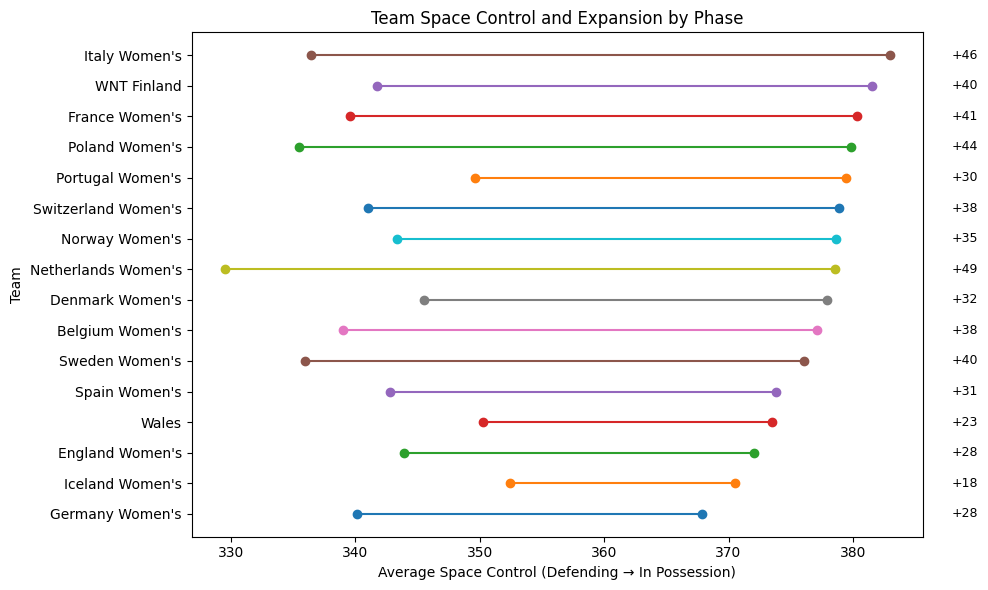

In [34]:
# Create visualization showing team space control and expansion
label_x = space_pivot["in_possession"].max() + 5 
plt.figure(figsize=(10, 6))

for _, row in space_pivot.iterrows():
    # Draw the line + dots
    plt.plot(
        [row["defending"], row["in_possession"]],
        [row["team"], row["team"]],
        marker="o"
    )
   
    plt.text(
        label_x,
        row["team"],
        f"+{int(row['expansion'])}",
        va="center",
        fontsize=9
    )

plt.xlabel("Average Space Control (Defending → In Possession)")
plt.ylabel("Team")
plt.title("Team Space Control and Expansion by Phase")
plt.tight_layout()
plt.show()

*Figure 1*

### How Do Teams Expand Their Shape When Transitioning From Defense to Attack?

**Interpretation:**  
Each team’s average space control while defending is shown on the left, with its in-possession
space control shown on the right. The connecting line represents the degree of spatial expansion
as teams transition from defense to attack.

This visualization reveals clear stylistic differences across teams. Some teams remain compact
defensively but expand aggressively in possession, while others maintain relatively consistent
spatial structures regardless of phase.

---

**Key Insights:**

- The Netherlands display one of the most compact defensive shapes in the dataset but expand
  substantially in possession (approximately +49 units), suggesting an attacking approach
  built around width and spatial stretching.

- Iceland remain compact both in and out of possession, showing minimal expansion (+18 units),
  which indicates a preference for maintaining structural stability rather than aggressively
  spreading the field when attacking.

- The wide variation in expansion values across teams suggests that space control is not a
  universal response to possession, but a stylistic choice shaped by team identity and
  tactical philosophy.

## 4. Match Results Analysis

### 4.1 Extract Goals Data


In [64]:
# Extract goals from events
goals = events[
    (events["type"] == "Shot") &
    (events["shot_outcome"] == "Goal")
].copy()

goals.head()

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_other,clearance_right_foot,counterpress,dribble_nutmeg,dribble_outcome,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_won_advantage,foul_won_defensive,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_technique,goalkeeper_type,id,index,injury_stoppage_in_chain,interception_outcome,location,match_id,minute,miscontrol_aerial_won,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_body_part,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure,block_deflection,dribble_overrun,foul_committed_type,pass_no_touch,shot_aerial_won,shot_deflected,bad_behaviour_card,block_offensive,foul_committed_offensive,foul_committed_penalty,foul_won_penalty,goalkeeper_punched_out,goalkeeper_shot_saved_off_target,pass_miscommunication,shot_saved_off_target,ball_recovery_offensive,dribble_no_touch,block_save_block,goalkeeper_penalty_saved_to_post,goalkeeper_shot_saved_to_post,shot_open_goal,shot_saved_to_post,shot_redirect,goalkeeper_lost_out,shot_follows_dribble
4592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.507510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19fe6b40-71be-42f7-b00f-fac90afaf811,1027,NaN,NaN,"[113.5, 38.7]",4020846,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,María Francesca Caldentey Oliver,10161.0,Left Wing,51,Spain Women's,863,[f1e2008d-3201-46ed-b84c-1262c8b5461e],11,Head,"[120.0, 43.7, 1.7]",NaN,"[{'location': [118.9, 40.9], 'player': {'id': ...",db852173-f83b-4ddc-9c18-c9e2dc577f98,NaN,Goal,0.395652,Normal,Open Play,NaN,NaN,NaN,NaN,NaN,Spain Women's,863,00:24:11.040,Shot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.085875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bde9fc38-558f-4f08-b84e-bf18ac7f7184,2420,NaN,NaN,"[113.0, 40.1]",4020846,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,From Throw In,Alessia Russo,47521.0,Center Forward,108,England Women's,865,[4610deba-a9a7-407a-88f4-fd1cc15517b9],4,Head,"[120.0, 37.0, 1.4]",NaN,"[{'location': [118.8, 40.5], 'player': {'id': ...",20ba4dcc-50d9-4848-b457-9aec748768eb,NaN,Goal,0.213453,Normal,Open Play,NaN,NaN,NaN,NaN,NaN,England Women's,865,00:11:04.064,Shot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.551603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71953e64-40e4-494b-a142-24eb99cb986a,4813,NaN,NaN,"[108.1, 40.1]",4020846,121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,Other,Patricia Guijarro Gutiérrez,15287.0,Center Defensive Midfield,225,Spain Women's,863,[19edfe98-b7a9-4ce8-9bbe-9e113097f3d5],43,Right Foot,"[120.0, 40.0, 1.4]",NaN,NaN,NaN,NaN,Goal,0.783500,Normal,Penalty,NaN,NaN,NaN,NaN,NaN,Spain Women's,863,00:01:43.390,Shot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

### 4.2 Calculate Match Results

In [65]:
# Calculate goals for each team per match
goals_for = (
    goals
    .groupby(["match_id", "team"])
    .size()
    .reset_index(name="goals_for")
)

# Calculate goals against by merging with opponent data
goals_against = (
    goals_for
    .merge(
        goals_for,
        on="match_id",
        suffixes=("_team", "_opp")
    )
)

# Remove rows where team == opponent
goals_against = goals_against[
    goals_against["team_team"] != goals_against["team_opp"]
]

goals_against = goals_against.rename(columns={
    "team_team": "team",
    "goals_for_team": "goals_for",
    "goals_for_opp": "goals_against"
})[["match_id", "team", "goals_for", "goals_against"]]

goals_against.head()

,match_id,team,goals_for,goals_against
2,3998837,Norway Women's,1,1
3,3998837,Switzerland Women's,1,1
11,3998843,England Women's,1,2
12,3998843,France Women's,2,1
16,3998845,Norway Women's,1,1


### 4.3 Determine Match Outcomes

In [78]:
# Determine match outcomes
match_results = goals_against.copy()

def get_outcome(row):
    if row["goals_for"] > row["goals_against"]:
        return "Win"
    elif row["goals_for"] < row["goals_against"]:
        return "Loss"
    else:
        return "Draw"

match_results["outcome"] = match_results.apply(get_outcome, axis=1)
match_results.head(20)

,match_id,team,goals_for,goals_against,outcome
2,3998837,Norway Women's,1,1,Draw
3,3998837,Switzerland Women's,1,1,Draw
11,3998843,England Women's,1,2,Loss
12,3998843,France Women's,2,1,Win
16,3998845,Norway Women's,1,1,Draw
17,3998845,WNT Finland,1,1,Draw
20,3998846,Italy Women's,1,1,Draw
21,3998846,Portugal Women's,1,1,Draw
24,3998847,Belgium Women's,2,6,Loss
25,3998847,Spain Women's,6,2,Win


### 4.4 Visualize Match Outcomes

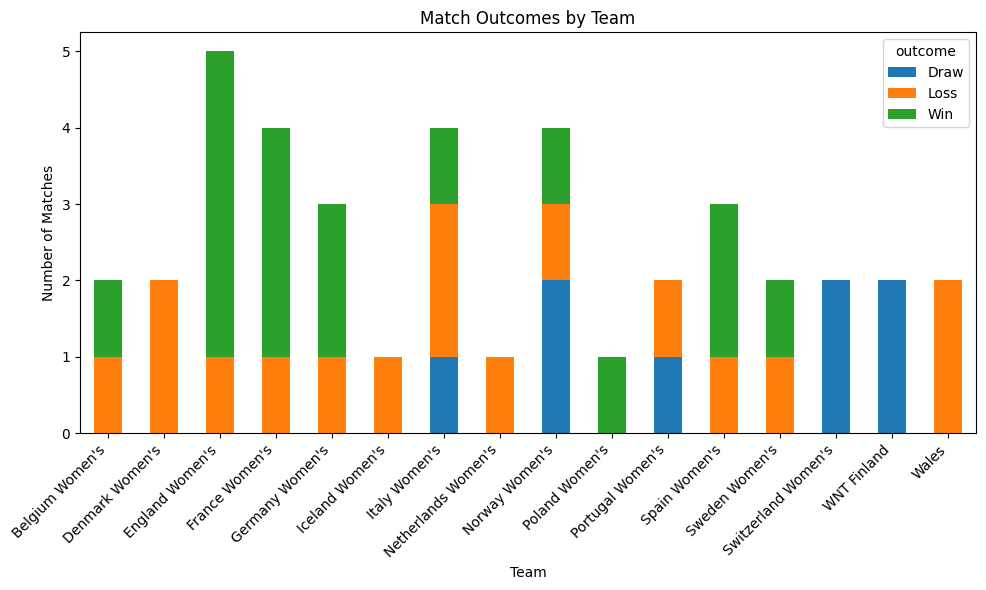

In [67]:
# Count outcomes by team
outcome_counts = (
    match_results
    .groupby(["team", "outcome"])
    .size()
    .reset_index(name="count")
)

# Pivot for visualization
outcome_pivot = outcome_counts.pivot(
    index="team",
    columns="outcome",
    values="count"
).fillna(0)

# Create stacked bar chart
outcome_pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6)
)

plt.xlabel("Team")
plt.ylabel("Number of Matches")
plt.title("Match Outcomes by Team")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

*Figure 2*

### Do Team Spatial Structure Metrics Relate to Match Outcomes?

This visualization summarizes match outcomes for each team to provide context for evaluating
whether differences in compactness and space control translate into on-field results.
Rather than treating spatial metrics as predictive, the goal here is to assess whether
any visible relationship exists between team shape and match success.

**Interpretation:**  
Match outcomes vary widely across teams with similar spatial profiles. While some teams that
expand aggressively in possession record more wins, other teams with comparable spatial
structure show mixed or inconsistent results. This suggests that team shape alone is
insufficient to explain match outcomes.

**Takeaway:**  
Compactness and space control appear to describe tactical style more reliably than competitive
success. These metrics provide important structural context but must be considered alongside
additional performance and contextual factors to evaluate match results.


## 5. Team Compactness 

### 5.1 Team Compactness In and Out Of Possession Maps



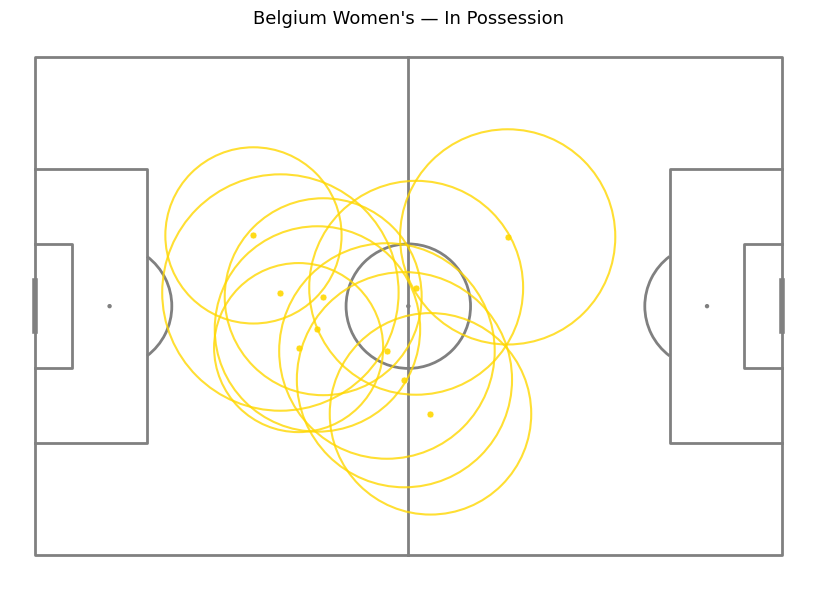

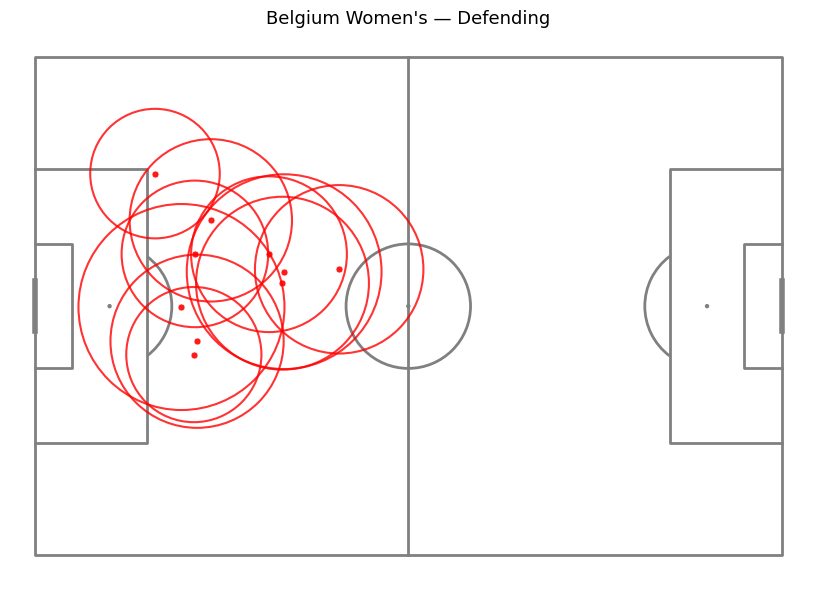

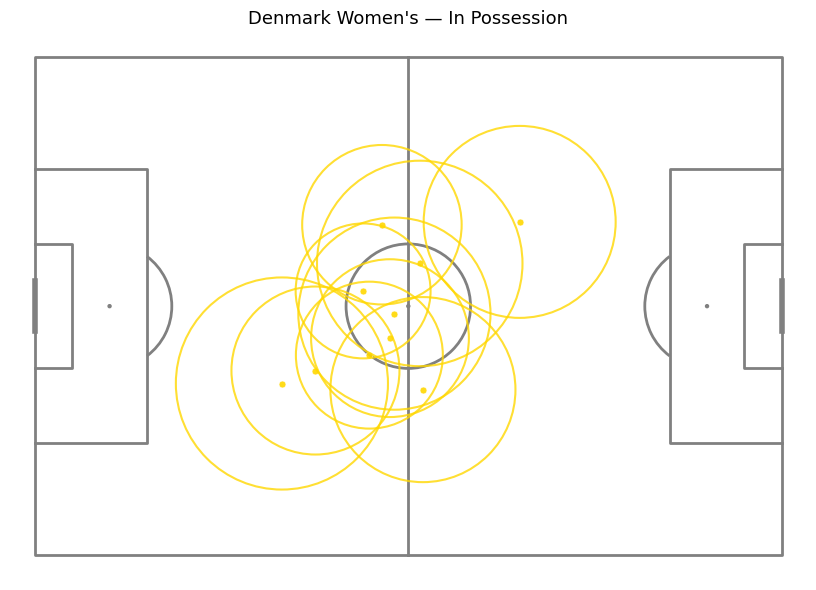

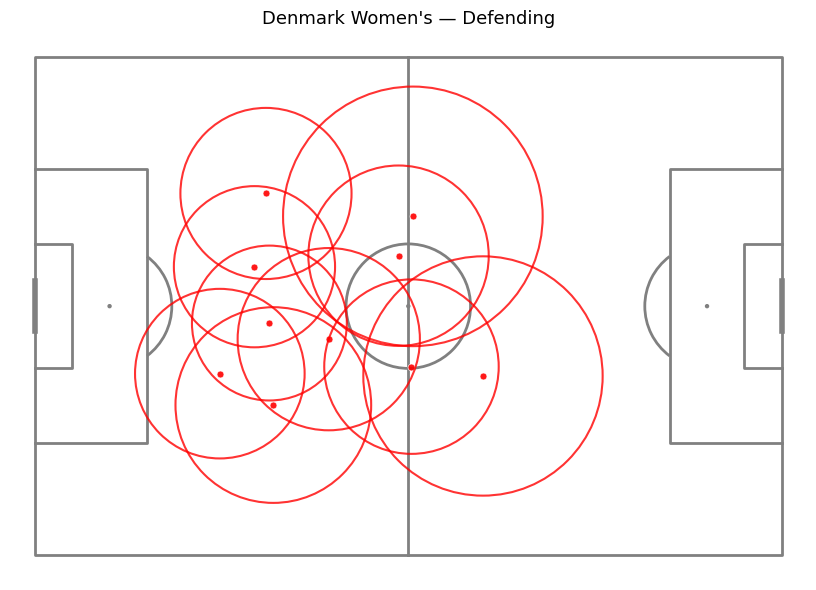

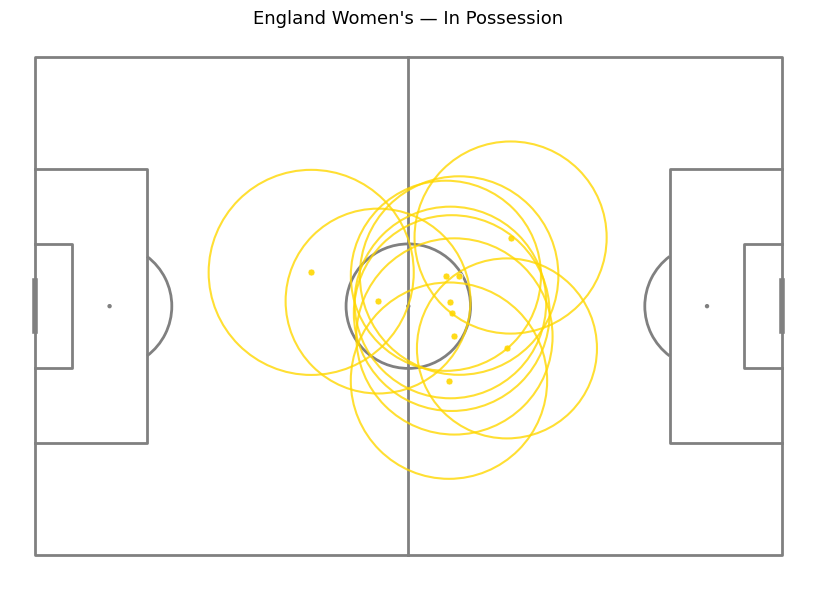

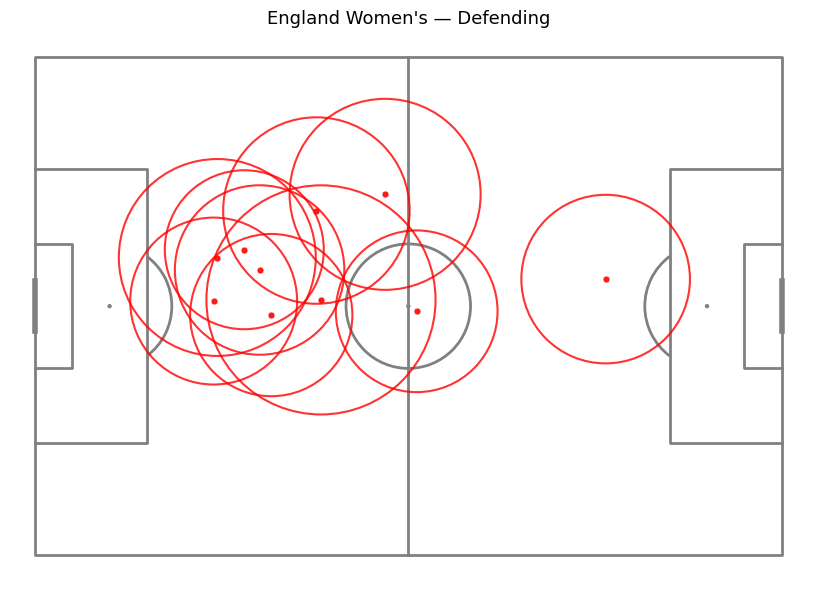

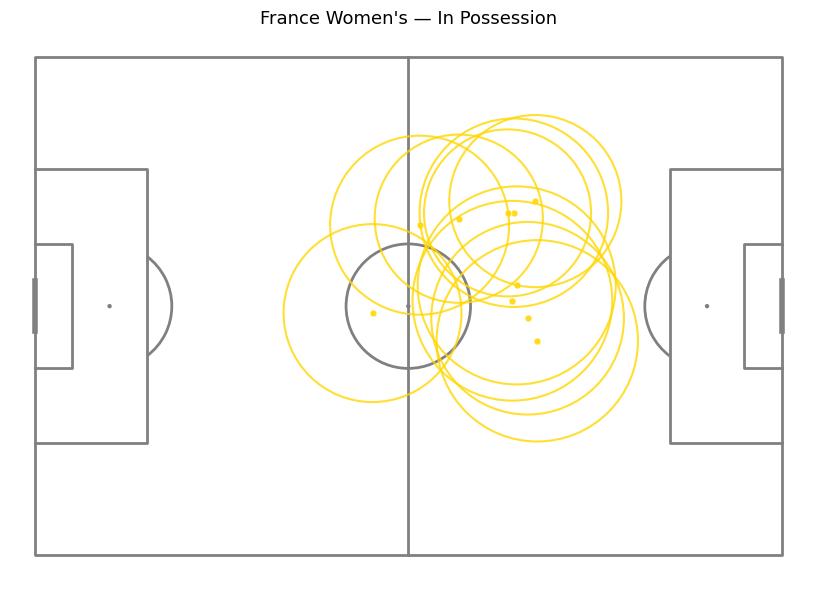

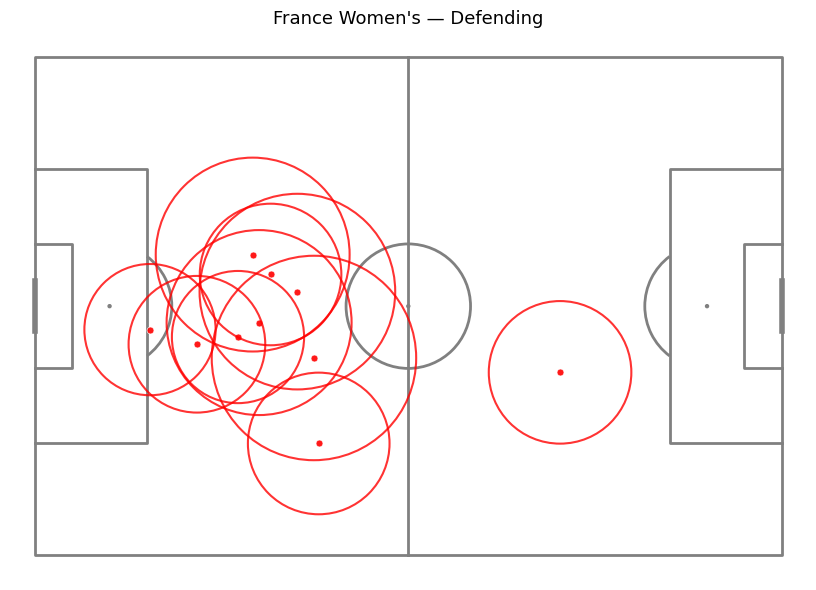

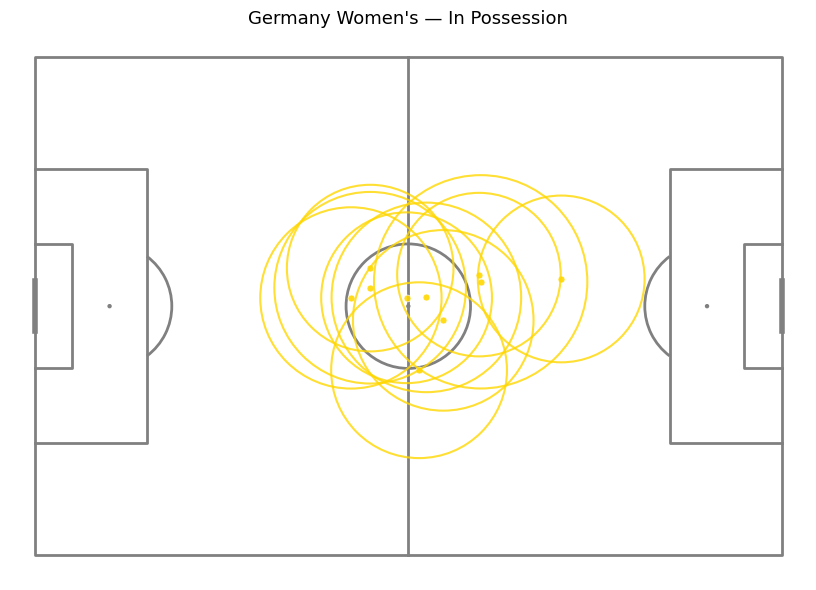

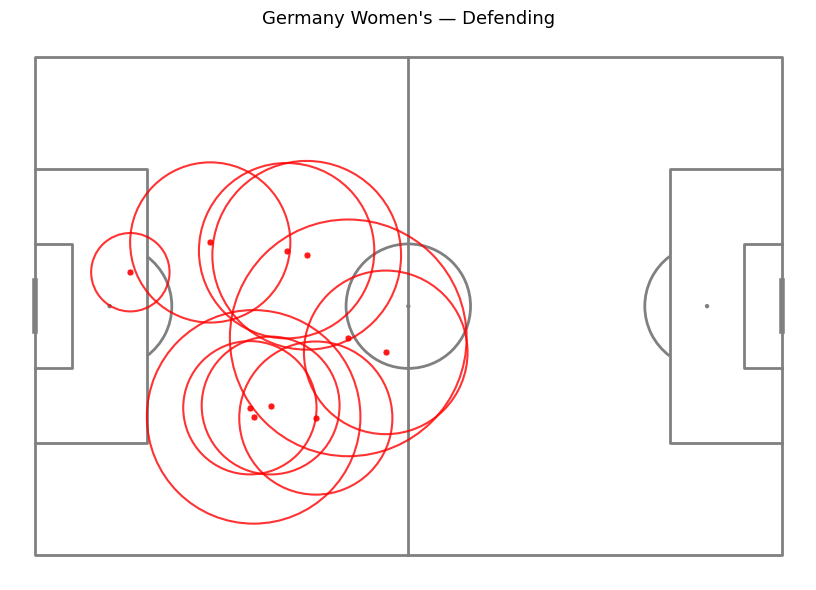

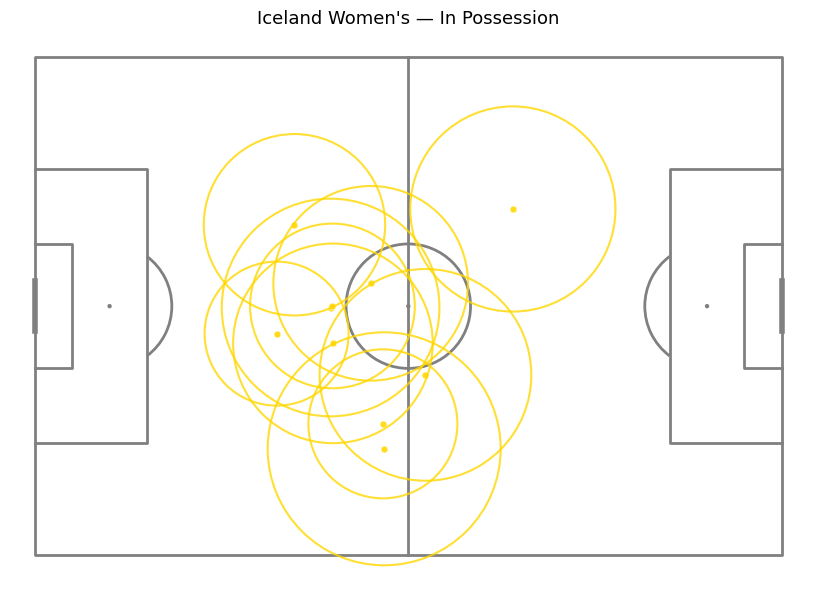

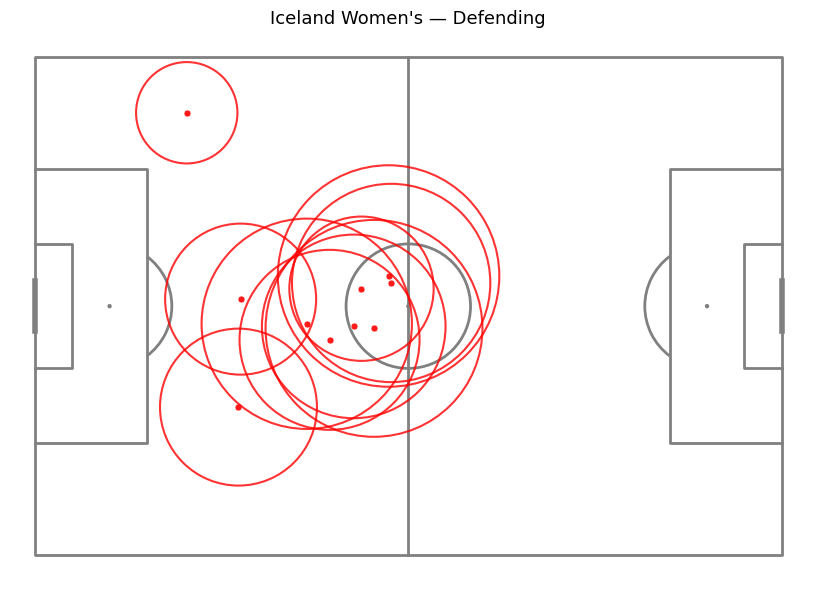

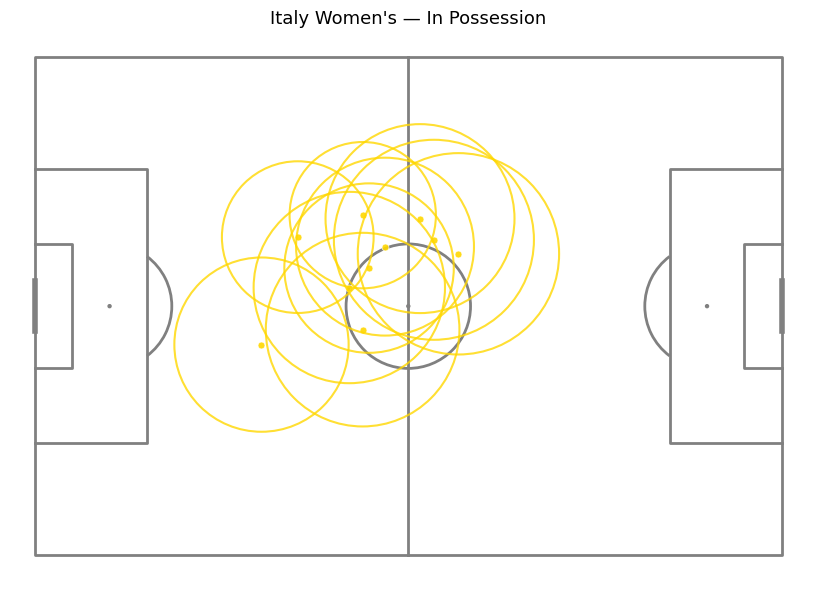

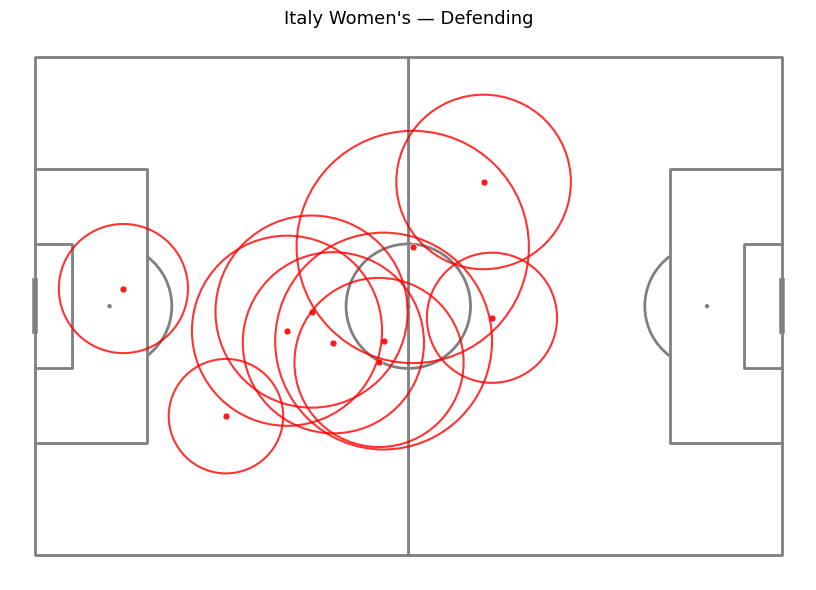

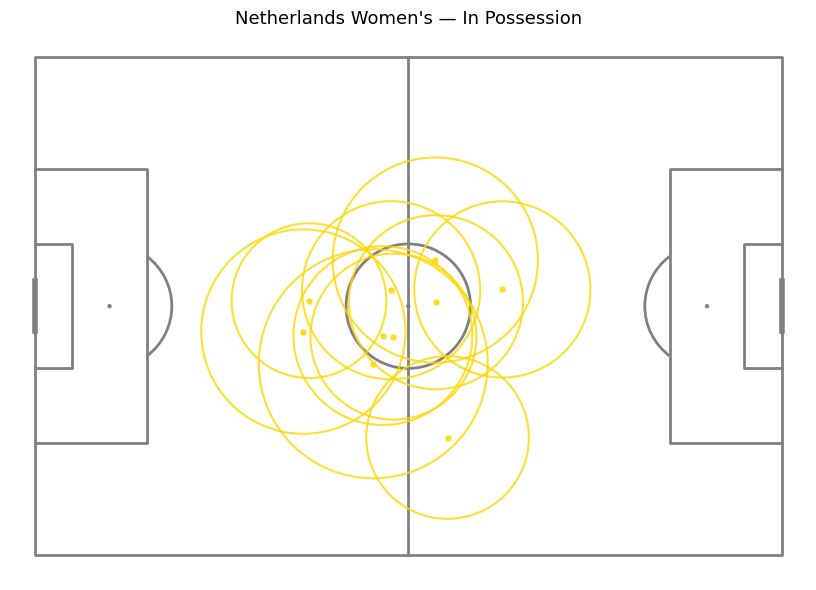

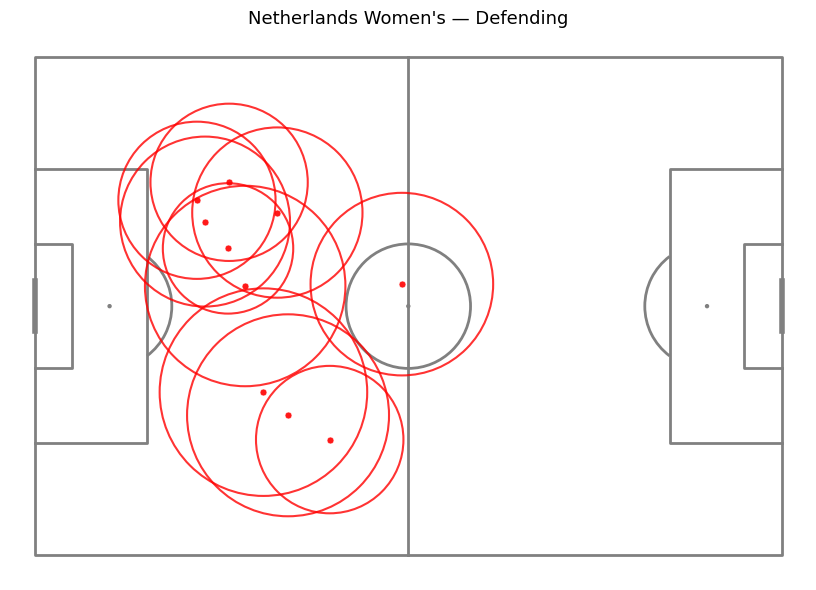

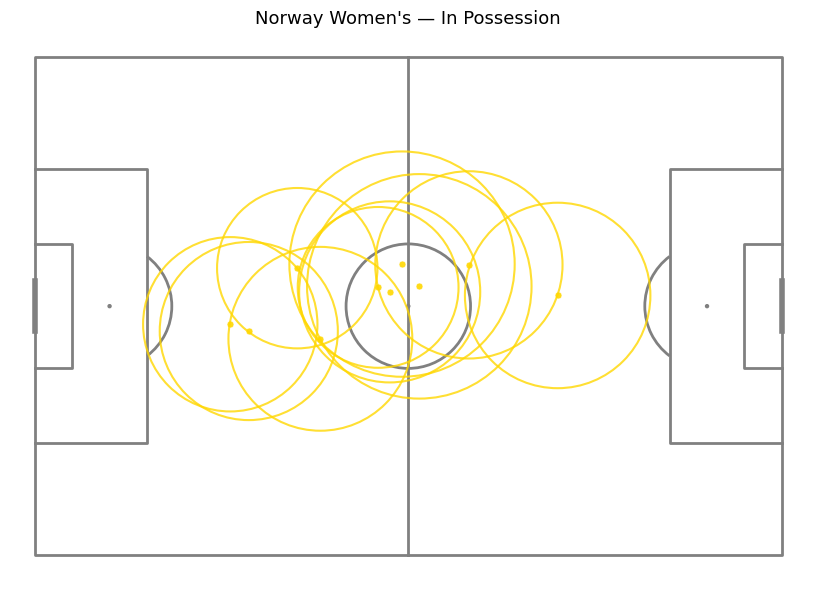

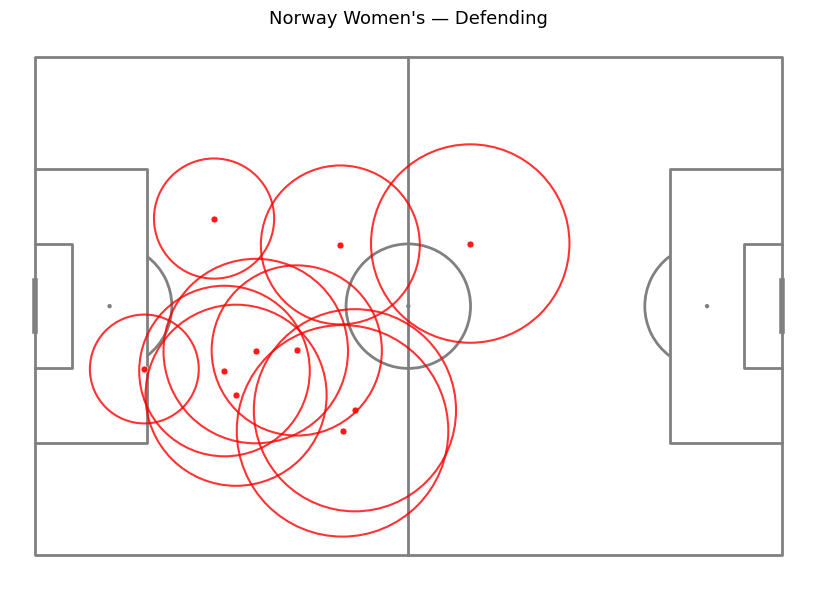

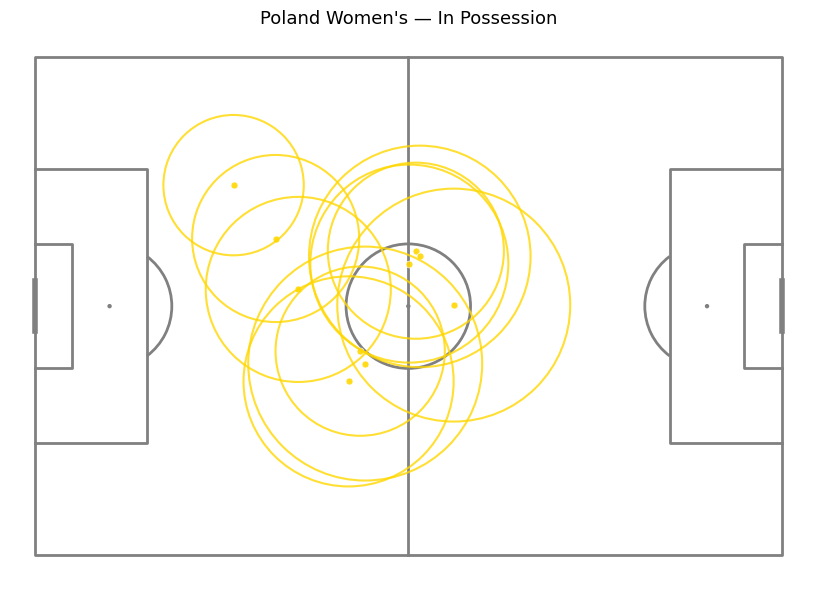

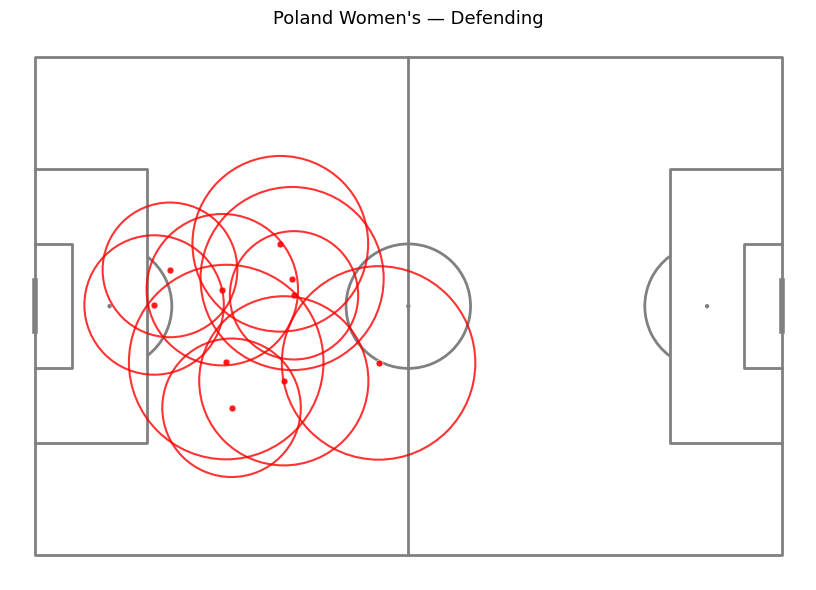

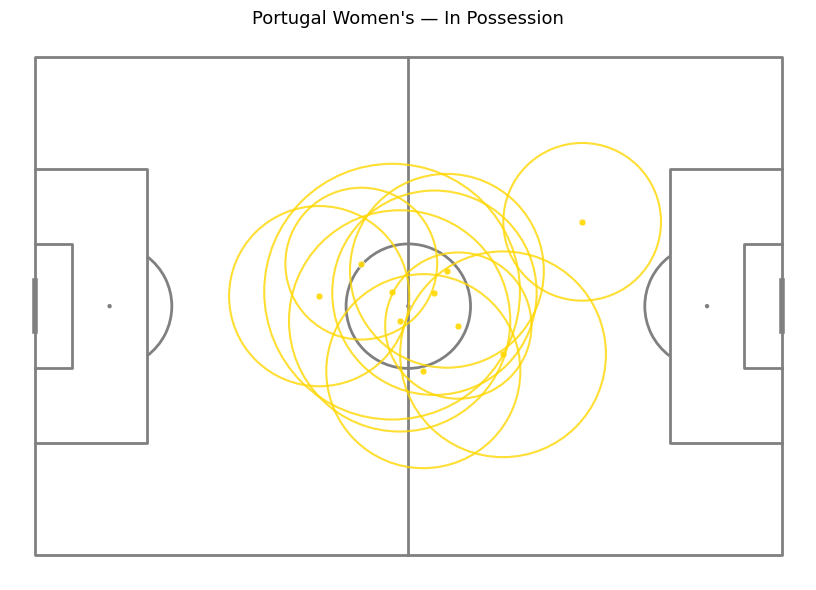

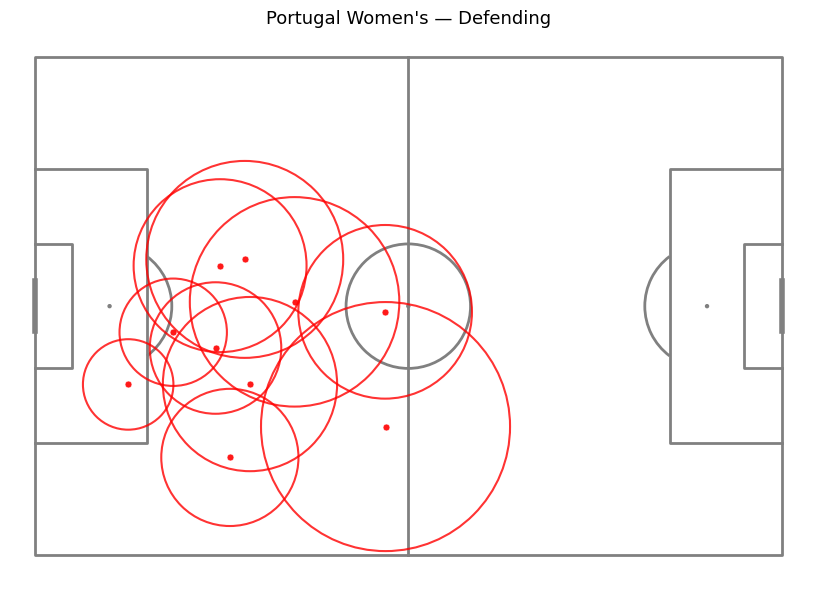

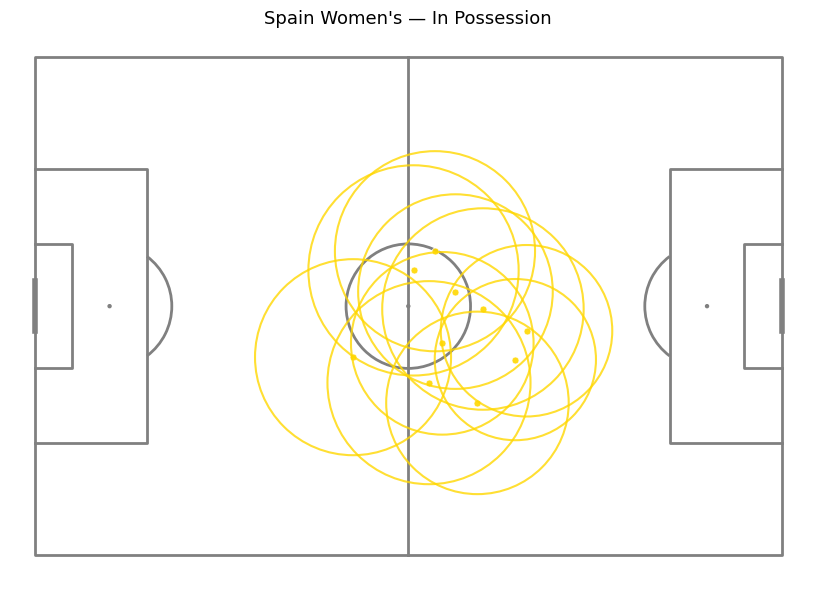

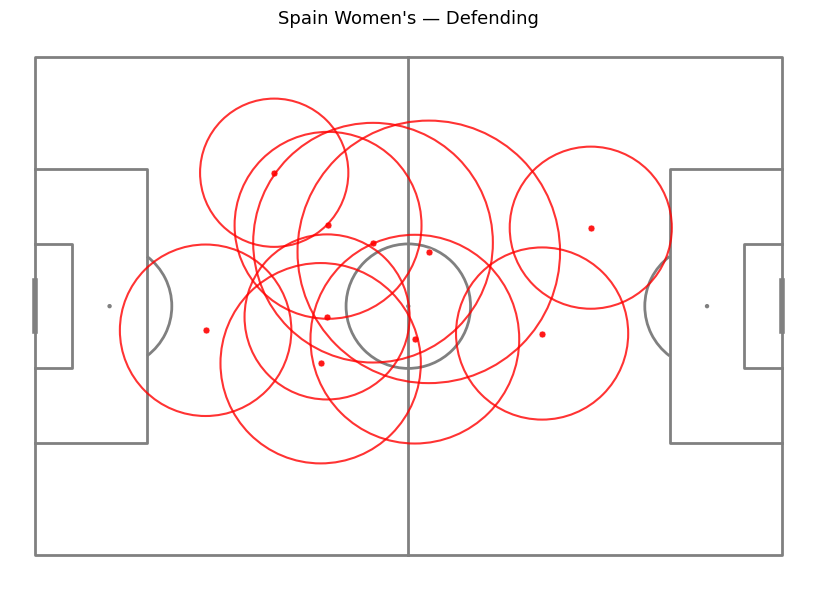

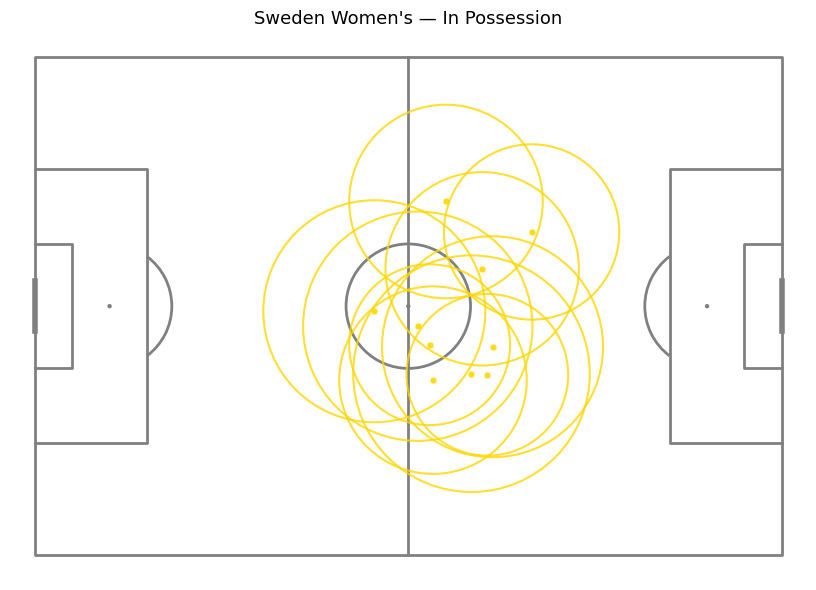

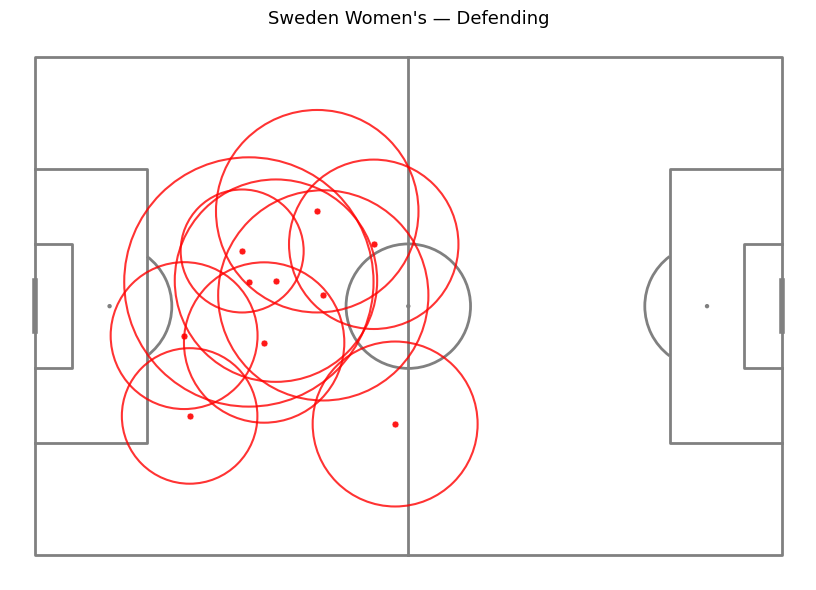

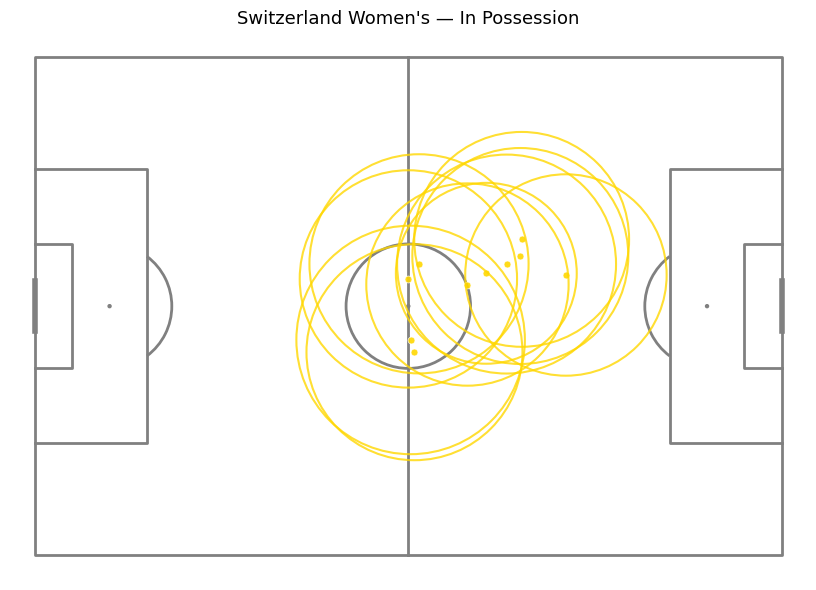

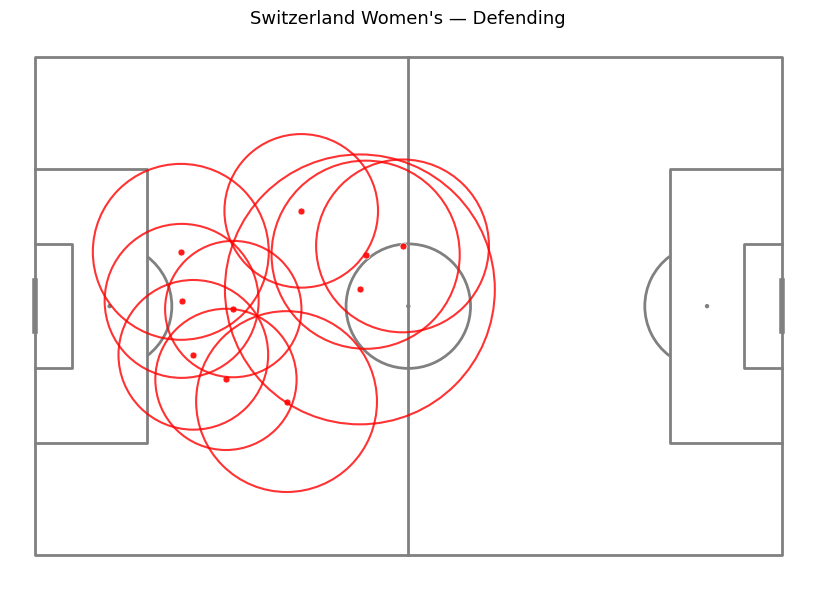

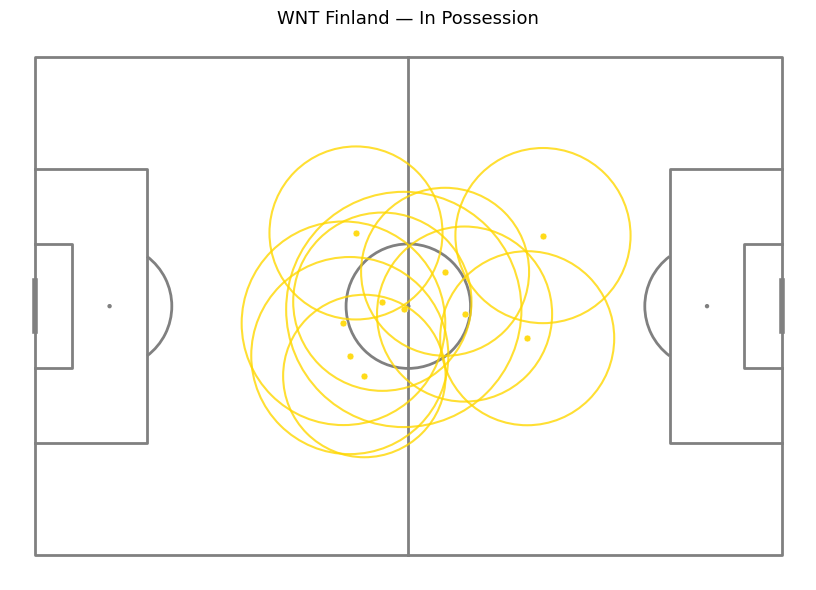

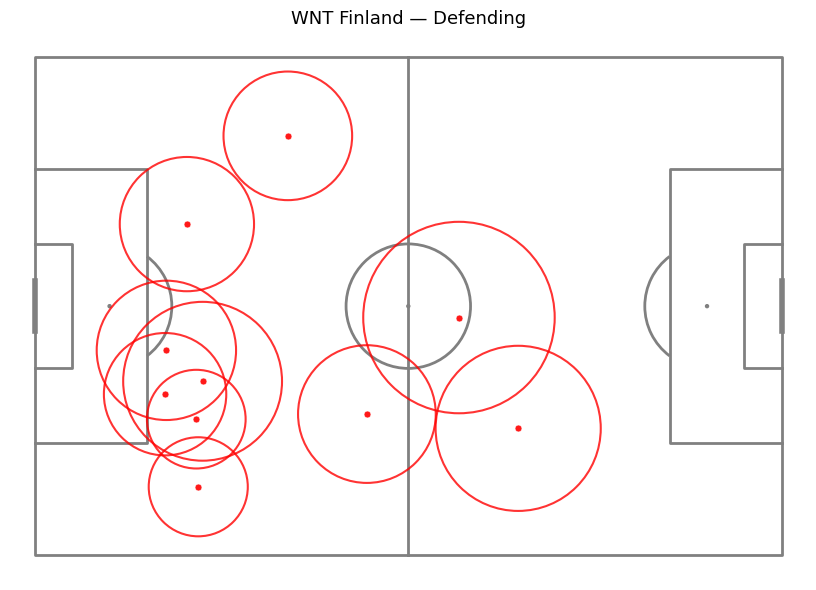

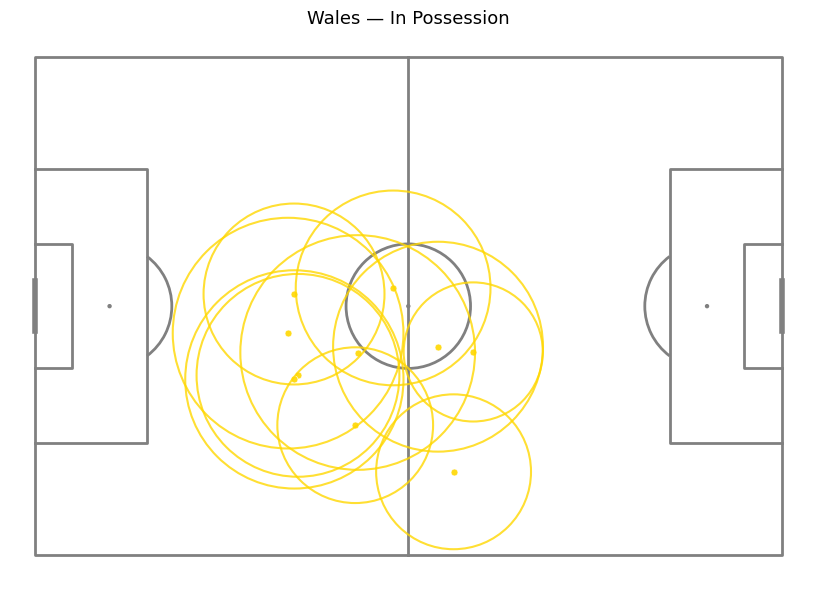

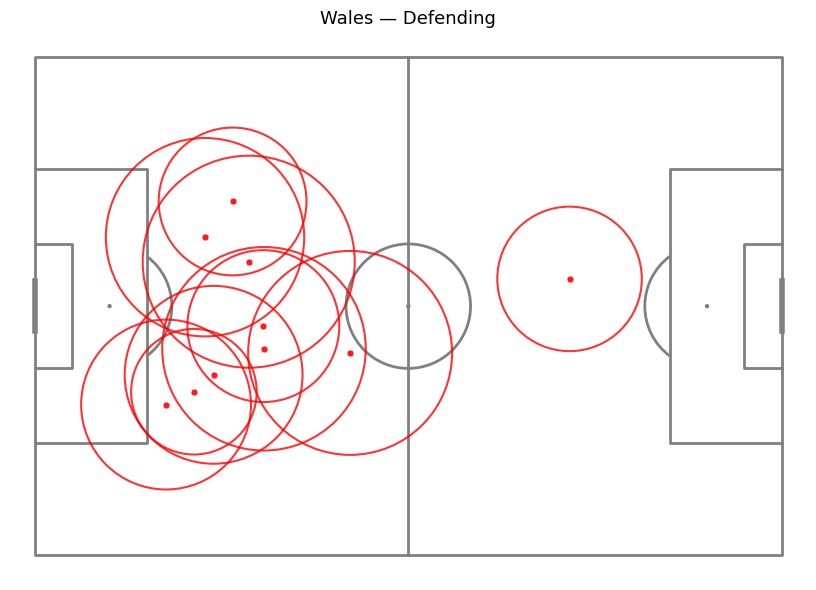

In [60]:
plot_team_compactness_maps(compactness_clean)

## Overview

The following visualizations show each team’s average positional structure during both
in-possession and out-of-possession phases. Each point represents a team’s mean on-pitch
position, while the surrounding circle visualizes the team’s compactness radius, calculated
using the standard deviation of player x- and y-coordinates.

Smaller circles indicate tighter, more compact team structures, while larger circles reflect
more dispersed positional shapes.

---

### Team Example: Belgium

Belgium display a clear contrast between attacking and defensive phases. In possession,
their positional shape is wider and more dispersed, covering much of the pitch width.
This suggests an attacking approach focused on stretching the opposition and utilizing wide areas.

Out of possession, Belgium’s structure becomes notably more compact, with player positions
concentrated closer to the defensive half. This indicates a preference for narrow defensive
organization and reduced space between lines when defending.

---

### Team Example: Germany

Germany exhibit a more compact and controlled positional structure in possession, with
player positioning remaining relatively tight and centralized. This suggests an emphasis
on maintaining structural cohesion rather than aggressive horizontal expansion.

Defensively, Germany’s compactness remains stable, with the team holding its shape higher
up the pitch rather than retreating deep into the defensive third. This consistency across
phases reflects a disciplined approach that prioritizes control during transitions and limits
large positional shifts between attacking and defensive moments. 

### 5.2 Average Compactness Visualizations

team
WNT Finland         26.909986
Belgium Women's     27.120386
Poland Women's      27.648585
Portugal Women's    27.721925
Denmark Women's     28.038180
Name: compactness_radius, dtype: float64

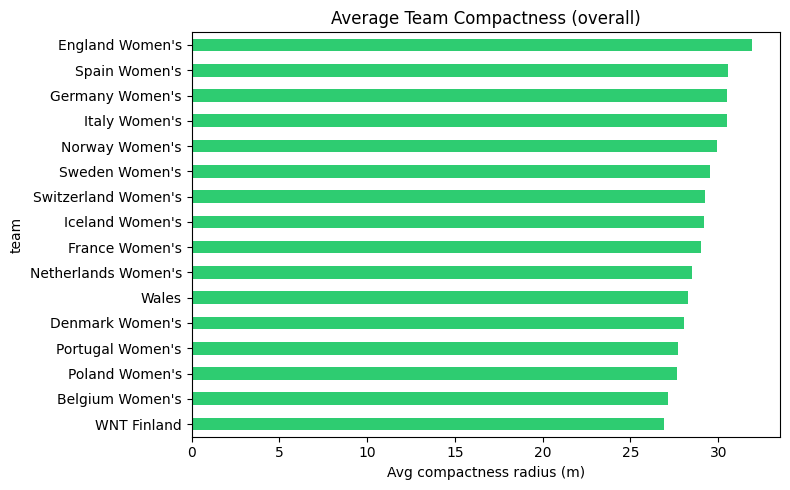

In [62]:

# Plot average team compactness and save visualization
fig, ax, avg_team = plot_avg_team_compactness(
    compactness_clean,
)
avg_team.head()

*Figure 3*

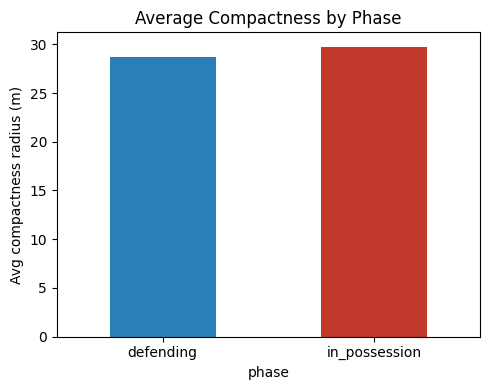

In [61]:
# Calculate and visualize average compactness by phase
phase_avg = compactness_clean.groupby('phase')['compactness_radius'].mean()

fig, ax = plt.subplots(figsize=(5, 4))
phase_avg.plot(kind='bar', color=['#2980b9', '#c0392b'], ax=ax)
ax.set_ylabel('Avg compactness radius (m)')
ax.set_title('Average Compactness by Phase')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

*Figure 4*

### How Does Team Compactness Vary by Phase and Across Teams?

**Interpretation:**  
The first visualization compares average team compactness by phase of play, with one bar representing compactness while defending and the other representing compactness when in possession. Compactness is measured as the average radius (in meters) of player positioning around the team’s centroid, where lower values indicate tighter spatial organization.

The second visualization presents average compactness across teams over the full dataset, enabling comparison of baseline spatial structure regardless of phase. Together, these visuals show how compactness shifts based on game context and how teams differ subtly in their overall spatial tendencies.

Overall, the plots indicate that teams consistently adopt tighter shapes while defending and expand slightly when in possession, reflecting widely used tactical principles around space denial versus space creation.

---

**Key Insights:**

- Teams are more compact on average during defensive phases than when in possession, highlighting a shared tactical emphasis on reducing space between players to limit passing lanes and central penetration.

- When in possession, teams expand their shape modestly, increasing the compactness radius. This expansion suggests a deliberate effort to create width, stretch the opposition, and support ball circulation rather than maintaining rigid positional structure.

- Average compactness values across teams cluster within a relatively narrow range, indicating that baseline spatial organization at the international level is fairly standardized. Differences between teams are present but subtle, reflecting stylistic variation rather than extreme tactical divergence.

- Variation in compactness is more pronounced across phases of play than across teams, suggesting that compactness is primarily driven by game context rather than fixed team identity. This reinforces its value as a situational spatial metric rather than a standalone indicator of performance.

--- 
# Key Points at a Glance

- Team spatial organization changes reliably based on phase of play, with defensive phases
  producing tighter structures and attacking phases producing controlled expansion.

- Teams differ in how aggressively they expand in possession, reflecting stylistic and
  tactical identity rather than a single dominant approach.

- Spatial structure metrics describe how teams play more effectively than how often they win,
  emphasizing their value as descriptive and contextual tools.

- Compactness and space control provide complementary perspectives on team behavior and are
  most informative when analyzed together.


--- 
# Final Takeaway

This analysis demonstrates how spatial metrics such as compactness and space control can be used
to quantify team structure and tactical style beyond traditional event-based statistics. Across
the UEFA Women’s Euro 2025 dataset, teams consistently adjust their spatial organization based on
phase of play, adopting tighter shapes when defending and expanding modestly in possession.

While these spatial patterns vary meaningfully across teams and phases, they show weak direct
relationships with match outcomes, reinforcing their value as descriptive indicators rather than
standalone predictors of success. Analyses like this can support tactical profiling, opponent
scouting, and style-based team comparison by providing structural context that complements
performance metrics.
